In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

D:\users\Rachid\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Datas

test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

In [3]:
# Missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = round(percent_1,1).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


In [4]:
# comments : with 77.1% of missing values, 'Cabin' columns need to be drop from the dataset

# What features could contribute to high rate of survival
# we don't need PassengerId , Name and ticker number

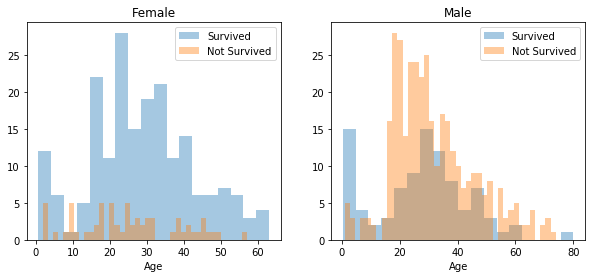

In [5]:
# Age and Sex
survived = 'survived'
not_survived = 'not survived'

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
women = train_df[train_df['Sex'] == 'female']
men = train_df[train_df['Sex'] == 'male']

ax = sns.distplot(women[women['Survived'] == 1].Age.dropna(),bins = 18,
                 label = 'Survived', ax = axes[0], kde=False)

ax = sns.distplot(women[women['Survived'] == 0].Age.dropna(),bins = 40,
                 label = 'Not Survived', ax = axes[0], kde=False)

ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['Survived'] == 1].Age.dropna(),bins = 18,
                 label = 'Survived', ax = axes[1], kde=False)

ax = sns.distplot(men[men['Survived'] == 0].Age.dropna(),bins = 40,
                 label = 'Not Survived', ax = axes[1], kde=False)

ax.legend()
_ = ax.set_title('Male')

plt.show()

D:\users\Rachid\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
D:\users\Rachid\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


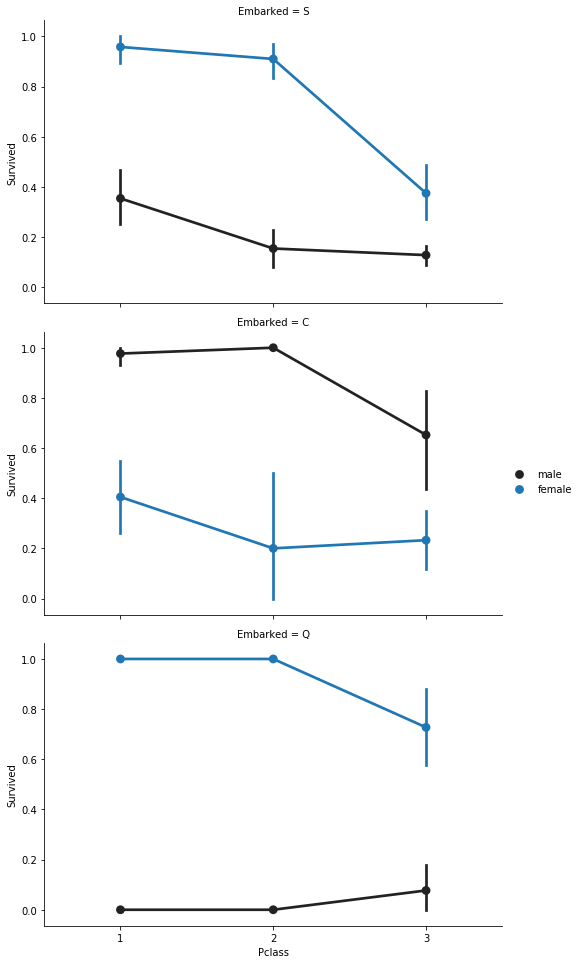

In [6]:
# Embarked Pclass and Sex
FacetGrid = sns.FacetGrid(train_df, row = 'Embarked',size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived','Sex', palette=None,
              order=None, hue_order=None)
FacetGrid.add_legend()

D:\users\Rachid\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


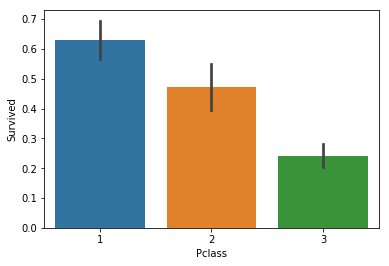

In [7]:
# PClass
sns.barplot(x='Pclass',y='Survived', data=train_df)

D:\users\Rachid\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


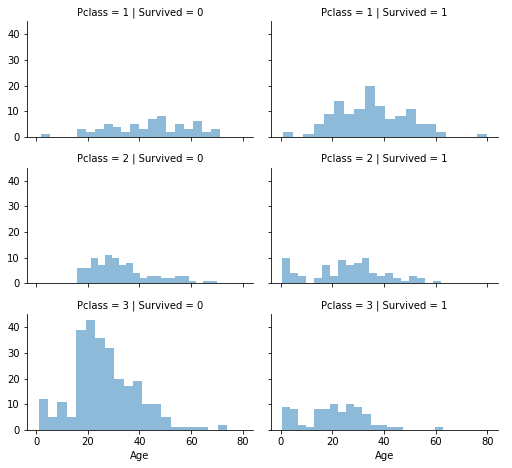

In [8]:
# Pclass / Survived / Age
grid = sns.FacetGrid(train_df, col='Survived', row = 'Pclass', size = 2.2, aspect = 1.6)
grid.map(plt.hist, 'Age', alpha = .5, bins = 20)
grid.add_legend()

D:\users\Rachid\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
D:\users\Rachid\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


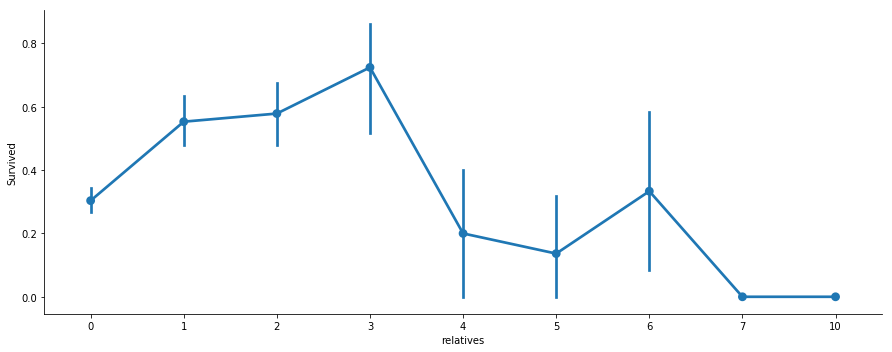

In [9]:
# sibsp : of siblings / spouses aboard the Titanic
# parch : of parents / children aboard the Titanic

data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
    
train_df['not_alone'].value_counts()

axes = sns.factorplot('relatives', 'Survived', data = train_df, aspect = 2.5)

In [10]:
# data preprocessing
train_df = train_df.drop(['PassengerId'], axis=1)

In [11]:
# fix Cabin issue
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x : re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
    
train_df = train_df.drop(['Cabin'], axis = 1)
test_df = test_df.drop(['Cabin'], axis = 1)

In [12]:
# Fix Age issue
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    
    rand_age = np.random.randint(mean-std, mean+std, size = is_null)
    
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)

In [13]:
# test
train_df["Age"].isnull().sum()

0

In [14]:
# Embarked Issue, fill with the common value
common_value = 'S'
data = [train_df, test_df]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [15]:
# Converting "Fare" from float to int64
data = [train_df, test_df]
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [16]:
# Extract Titles from Name and convert to number
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','COl','Don','Dr',
           'Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')
    dataset['Title'] = dataset['Title'].map(titles)
    dataset['Title'] = dataset['Title'].fillna(0)

In [17]:
# drop Name column
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [18]:
# drop Ticket column
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [20]:
# Convert 'Male' into numeric
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [21]:
# convert Embarked feature into numeric
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [22]:
# Creating Categories
    #♥ Categories fo Age
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[dataset['Age'] > 66, 'Age'] = 6

    # Categories for Fare
data = [train_df, test_df]

for dataset in data:
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <=14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <=31), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <=994), 'Fare'] = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <=250), 'Fare'] = 4
    dataset.loc[dataset['Fare'] > 250, 'Fare'] = 5
    dataset[ 'Fare'] = dataset['Fare'].astype(int)

In [23]:
# Creating New features
# Age times class

data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class'] = dataset['Age'] * dataset['Pclass']

# Fare per Person
data = [train_df, test_df]
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

In [24]:
# Building Machine Learning
# define train set and test set
x_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
x_test = test_df.drop("PassengerId", axis=1).copy()

In [25]:
# Stochastic Gradient Descent
sgd = linear_model.SGDClassifier(max_iter = 5, tol = None)
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)

sgd.score(x_train, y_train)

acc_sgd = round(sgd.score(x_train, y_train)*100, 2)
print(acc_sgd)

77.78


In [26]:
# Random forest
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(x_train, y_train)

y_prediction = random_forest.predict(x_test)

random_forest.score(x_train, y_train)
acc_random_forest = round(random_forest.score(x_train, y_train)*100, 2)
print(acc_random_forest)

92.7


In [27]:
# Logisitc Regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

acc_logreg = round(logreg.score(x_train, y_train)*100, 2)
print(acc_logreg)

81.93


In [28]:
# K Nearest Neighbor
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

acc_knn = round(knn.score(x_train, y_train)*100, 2)
print(acc_knn)

86.98


In [29]:
#♠ Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_test)

acc_gaussian = round(gaussian.score(x_train, y_train) * 100, 2)
print(acc_gaussian)

78.23


In [30]:
# Perceptron
perceptron = Perceptron(max_iter = 5)
perceptron.fit(x_train, y_train)

y_pred = perceptron.predict(x_test)

acc_perceptron = round(perceptron.score(x_train, y_train)*100,2)
print(acc_perceptron)

78.79


In [31]:
# Linear SVM
linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)

y_pred = linear_svc.predict(x_test)

acc_linear_svc = round(linear_svc.score(x_train, y_train)*100, 2)
print(acc_linear_svc)

81.37


In [32]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

y_pred = decision_tree.predict(x_test)

acc_decision_tree = round(decision_tree.score(x_train, y_train)*100, 2)
print(acc_decision_tree)

92.7


In [33]:
# Which is the best model
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_logreg, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending = False)
result_df = result_df.set_index('Score')
result_df

,Model
Score,
92.70,Random Forest
92.70,Decision Tree
86.98,KNN
81.93,Logistic Regression
81.37,Support Vector Machines
78.79,Perceptron
78.23,Naive Bayes
77.78,Stochastic Gradient Decent


In [34]:
# K-fold Cross Validation Performance
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators = 100)
scores = cross_val_score(rf, x_train, y_train, cv=10, scoring = 'accuracy')

print("Scores: ", scores)
print("Mean: ", scores.mean())
print("Standard deviation :", scores.std())

Scores:  [0.77777778 0.81111111 0.74157303 0.84269663 0.88764045 0.84269663
 0.79775281 0.76404494 0.84269663 0.84090909]
Mean:  0.8148899103393485
Standard deviation : 0.042349881356660554


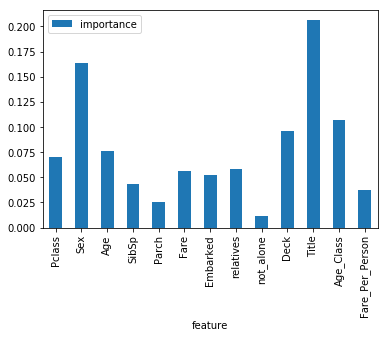

In [36]:
# Feature importance
importances = pd.DataFrame({'feature':x_train.columns, 
                            'importance':np.round(random_forest.feature_importances_, 3)})
importances.sort_values('importance', ascending = False).set_index('feature')

importances.plot.bar(x = 'feature')

In [37]:
'''
not_alone and Parch doesn’t play a significant role in our 
random forest classifiers prediction process.
'''

x_train = x_train.drop('not_alone', axis = 1)
x_test = x_test.drop('not_alone', axis = 1)

x_train = x_train.drop('Parch', axis = 1)
x_test = x_test.drop('Parch', axis = 1)

In [38]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators = 100, oob_score = True)
random_forest.fit(x_train, y_train)
Y_prediction = random_forest.predict(x_test)

acc_random_forest_2 = round(random_forest.score(x_train, y_train)*100, 2)
print(acc_random_forest_2)

92.7


# Hyperparameter Tuning
param_grid = {'criterion' : ['gini', 'entropy'], 'min_samples_leaf':[1,5,10,25,50,70],
              'min_samples_split' : [2,4,10,12,16,18,25,35], 
              'n_estimators' : [100,400,700,1000,1500]}

from sklearn.model_selection import GridSearchCV, cross_val_score

rf = RandomForestClassifer(n_estimators = 100, max_features = 'auto', 
                           oob_score = True, random_state = 1, n_jobs = -1)

clf = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1)
clf.fit(x_train, y_train)
clf.bestparam

'''Bests Param

{'criterion' : 'gini',
'min_sample_leaf' : 1,
'min_samples_split' : 10,
'n_estimators' : 100}

'''

In [39]:
# Test New parameters
random_forest = RandomForestClassifier(criterion = 'gini',
                                       min_samples_leaf = 1,
                                       min_samples_split = 100,
                                       n_estimators = 100,
                                       max_features = 'auto',
                                       oob_score = True,
                                       random_state = 1,
                                       n_jobs = -1)

random_forest.fit(x_train, y_train)
Y_prediction = random_forest.predict(x_test)
acc_random_forest_3 = round(random_forest.score(x_train, y_train) * 100, 2)
print(acc_random_forest_3)

83.95


In [41]:
# confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

predictions = cross_val_predict(random_forest, x_train, y_train, cv=3)
cm = confusion_matrix(y_train, predictions)
print(cm)

[[493  56]
 [ 94 248]]


In [42]:
# Precision and recall
from sklearn.metrics import precision_score, recall_score
print("Precision: ", round(precision_score(y_train, predictions) * 100, 2))
print("Recall: ", round(recall_score(y_train, predictions)*100,2))

Precision:  81.58
Recall:  72.51


In [43]:
# F-score
'''
The F-score is computed with the harmonic mean of precision and recall. 
Note that it assigns much more weight to low values. As a result of that, 
the classifier will only get a high F-score, if both recall and precision are high.
'''
from sklearn.metrics import f1_score
print(f1_score(y_train, predictions))


0.7678018575851393


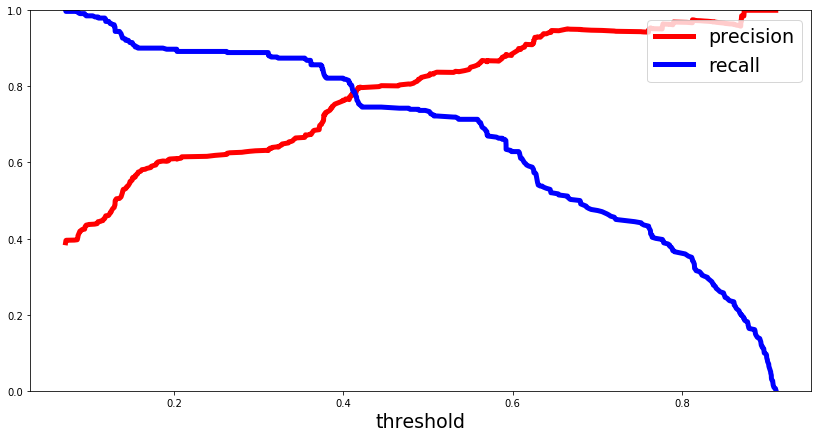

In [44]:
# plot precision and recall
from sklearn.metrics import precision_recall_curve
y_scores = random_forest.predict_proba(x_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)

def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

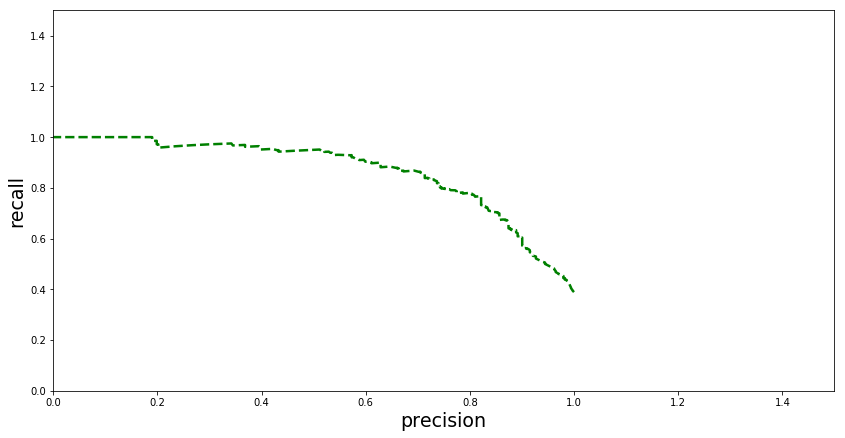

In [45]:
# Plot precision and recall against each other
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth = 2.5)
    plt.ylabel("recall", fontsize = 19)
    plt.xlabel("precision", fontsize = 19)
    plt.axis([0,1.5,0,1.5])
    
plt.figure(figsize=(14,7))
plot_precision_vs_recall(precision, recall)
plt.show()

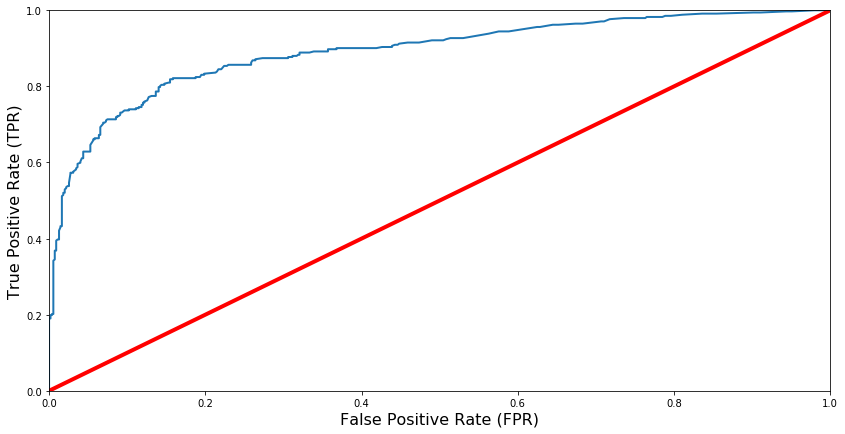

In [46]:
# ROC AUC Curve
from sklearn.metrics import roc_curve
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, y_scores)

def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [47]:
# ROC AUC Score
from sklearn.metrics import roc_auc_score
r_a_score = round(roc_auc_score(y_train, y_scores) * 100, 2)
print(r_a_score)

89.15
